In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

For this stage, we will fit 2 models to use as benchmark models:

* **First model**: We will fit a linear regression with all the features, only performing a standard scaling.
* **Second model**: we will perform a power transformation to obtain gaussian variables and then proceed with a feature selection to identify the ost relevant variables

For both models, we will use the iterative imputer provided by scikit-learn to fill NaN's that are present.

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    mutual_info_regression,
    f_regression,
)
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RepeatedKFold,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler


from urbana.features import normaltests
from urbana.constants import DIR_REPO, DIR_DATA, RANDOM_STATE
from urbana.models.plot_predictions import PredictedAccuracy

cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 5
K_RENT = 1
VARIABLE_TO_PREDICT = "Airbnb_Number"

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

In [6]:
np.random.seed(RANDOM_STATE)

neigh = pd.read_csv(
    DIR_DATA / "interim/neighbourhoods.csv",
)

neigh.set_index("Tag", inplace=True)

neigh.drop(["N_district", "N_neighbourhood"], axis=1, inplace=True)

In [7]:
y = neigh[VARIABLE_TO_PREDICT]

X = neigh.drop(
    ["Airbnb_Number", "Airbnb_Price", "Airbnb_Price_Person", "Airbnb_Location_Score"],
    axis=1,
)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Target variable

In [8]:
target = gpd.read_file(DIR_DATA / "interim/neighbourhoods_geo.json")
target = target[["Tag", "geometry", VARIABLE_TO_PREDICT]]
target.set_index("Tag", inplace=True)

'02_07'

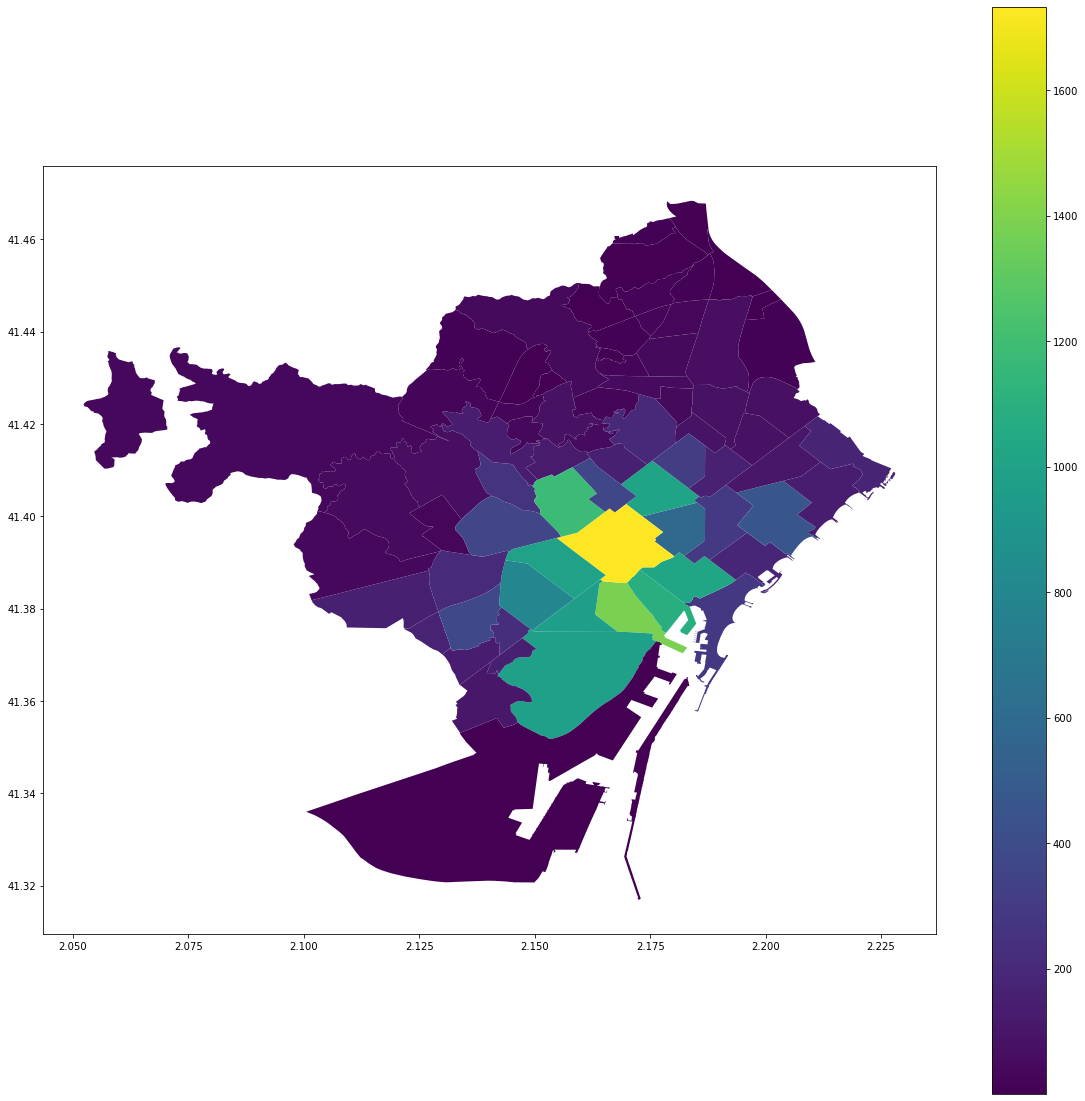

In [9]:
target.plot(column=VARIABLE_TO_PREDICT, legend=True, figsize=(20, 20))
target[VARIABLE_TO_PREDICT].idxmax()

# First model: All features

## Pipeline fit

In [10]:
pipe_all = Pipeline(
    steps=[
        ("imputer", IterativeImputer()),
        ("regressor", LinearRegression()),
    ]
)

In [11]:
pipe_all.fit(X_train, y_train)

y_test_pred_all = pipe_all.predict(X_test)

## Prediction plot

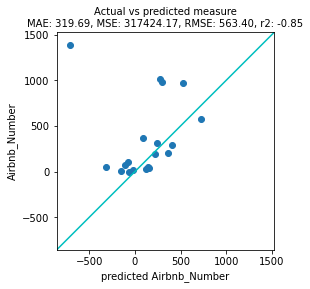

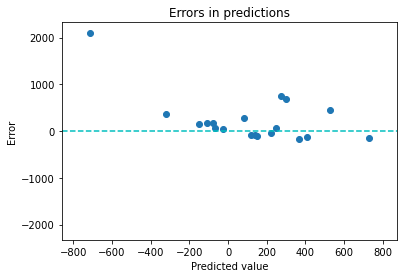

In [12]:
pa_all = PredictedAccuracy(y_test, y_test_pred_all)
pa_all.plot_scatter()

## Sensitivity analysis

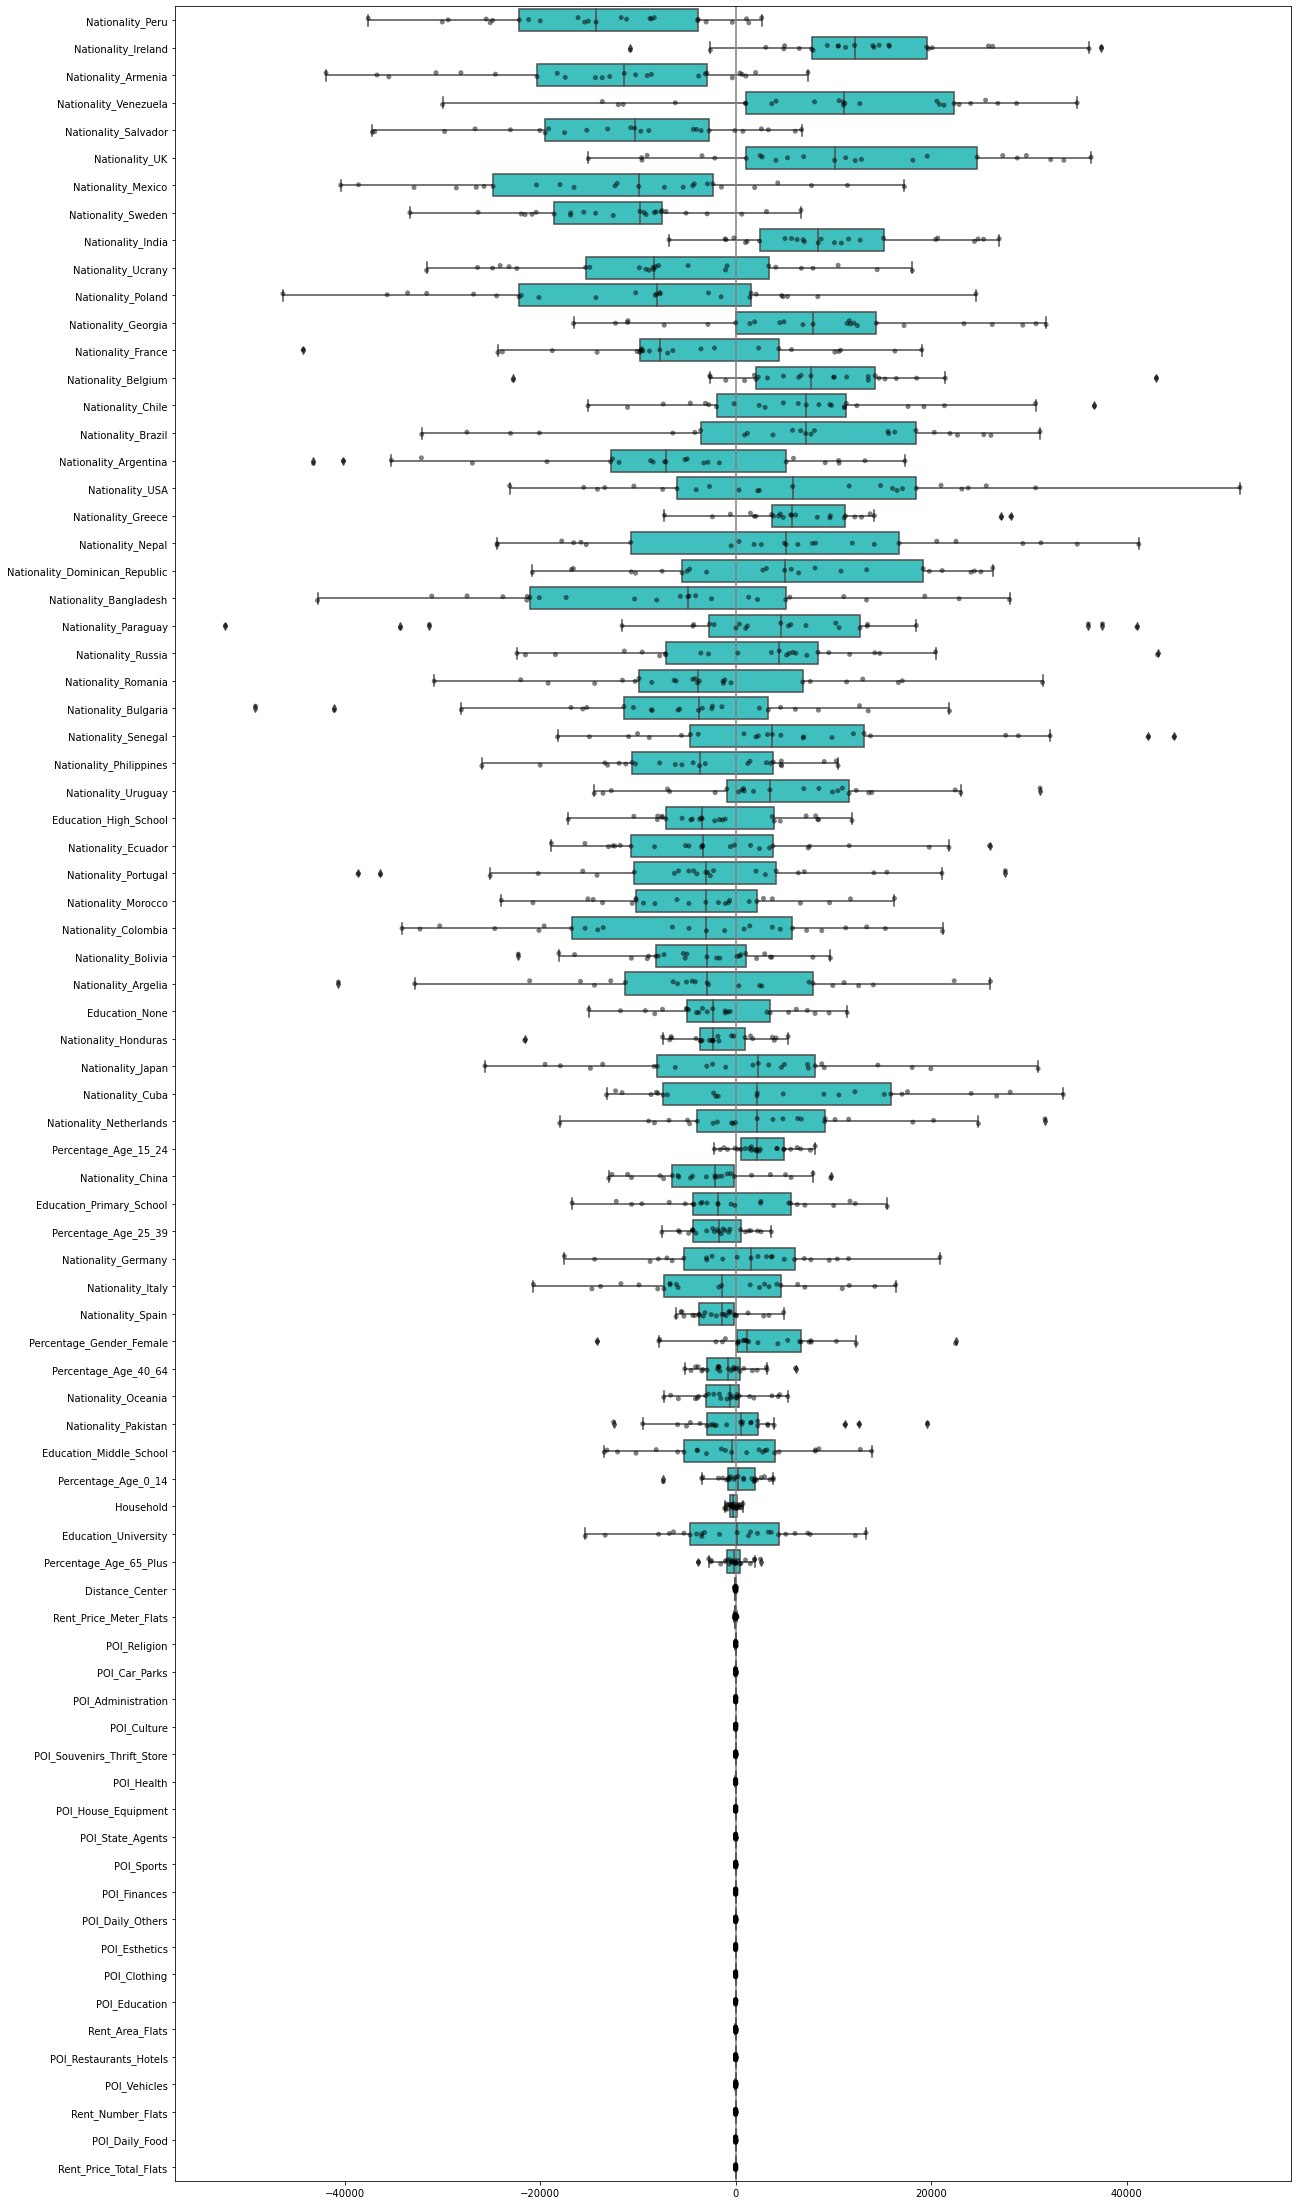

In [13]:
cv_all = cross_validate(
    pipe_all,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

medians_all = coefs_all.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
coefs_all = coefs_all[medians_all.index]


plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")

# Second model: Transformations and feature selection

## Normality tests

In [14]:
# Check which variables are already normal
normality_test = normaltests.get_normaltest_df(X_train.T)

print(normality_test["dagostino"].value_counts())
print(normality_test["shapiro"].value_counts())

False    68
True     11
Name: dagostino, dtype: int64
False    69
True     10
Name: shapiro, dtype: int64


## Preprocessing Pipeline

The preprocessing will have two phases:
* IterativeImputer: To imput missing data by fitting models (better than imputing the mean or the median)
* PowerTransformer: Since none of the features is Gaussian, we will transform them with the *Yeo-Johnson* transformation

In [15]:
pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", IterativeImputer()), ("pt", pt)])

## Feature Selection by Subgroups

In [16]:
X_Education = X_train.filter(regex="^Education")
kbest_Education = SelectKBest(mutual_info_regression, k=K_EDUCATION).fit(
    preprocessor.fit_transform(X_Education),
    pt.fit_transform(y_train.values.reshape(-1, 1)),
)

education_cols = kbest_Education.get_support(indices=True)
X_Education_chosen = X_Education.columns[education_cols]
X_Education_chosen

Index(['Education_University'], dtype='object')

In [17]:
X_Age = X_train.filter(regex="^Percentage_Age_")
kbest_Age = SelectKBest(mutual_info_regression, k=K_AGE).fit(
    preprocessor.fit_transform(X_Age),
    pt.fit_transform(y_train.values.reshape(-1, 1)),
)

age_cols = kbest_Age.get_support(indices=True)
X_Age_chosen = X_Age.columns[age_cols]
X_Age_chosen

Index(['Percentage_Age_25_39', 'Percentage_Age_65_Plus'], dtype='object')

In [18]:
X_Nationality = X_train.filter(regex="^Nationality_")
kbest_Nationality = SelectKBest(mutual_info_regression, k=K_NATIONALITY).fit(
    preprocessor.fit_transform(X_Nationality),
    pt.fit_transform(y_train.values.reshape(-1, 1)),
)

nationality_cols = kbest_Nationality.get_support(indices=True)
X_Nationality_chosen = X_Nationality.columns[nationality_cols]
X_Nationality_chosen

Index(['Nationality_France', 'Nationality_UK', 'Nationality_Mexico',
       'Nationality_Japan', 'Nationality_Oceania'],
      dtype='object')

In [19]:
X_Rent = X_train.filter(regex="^Rent_")
kbest_Rent = SelectKBest(mutual_info_regression, k=K_RENT).fit(
    preprocessor.fit_transform(X_Rent),
    pt.fit_transform(y_train.values.reshape(-1, 1)),
)

rent_cols = kbest_Rent.get_support(indices=True)
X_Rent_chosen = X_Rent.columns[rent_cols]
X_Rent_chosen

Index(['Rent_Number_Flats'], dtype='object')

In [20]:
X_train.drop(np.setdiff1d(X_Rent.columns, X_Rent_chosen), axis=1, inplace=True)
X_test.drop(np.setdiff1d(X_Rent.columns, X_Rent_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_Rent.columns, X_Rent_chosen), axis=1, inplace=True)

X_train.drop(np.setdiff1d(X_Age.columns, X_Age_chosen), axis=1, inplace=True)
X_test.drop(np.setdiff1d(X_Age.columns, X_Age_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_Age.columns, X_Age_chosen), axis=1, inplace=True)


X_train.drop(
    np.setdiff1d(X_Nationality.columns, X_Nationality_chosen), axis=1, inplace=True
)
X_test.drop(
    np.setdiff1d(X_Nationality.columns, X_Nationality_chosen), axis=1, inplace=True
)
X.drop(np.setdiff1d(X_Nationality.columns, X_Nationality_chosen), axis=1, inplace=True)


X_train.drop(
    np.setdiff1d(X_Education.columns, X_Education_chosen), axis=1, inplace=True
)
X_test.drop(np.setdiff1d(X_Education.columns, X_Education_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_Education.columns, X_Education_chosen), axis=1, inplace=True)

## Feature Selection Pipeline

In order to perform a feature selection, we will use *RFE* (Recursive Feature Elimination).

The number of variables to use will be a hyper-paramater that will be tuned with a GridSearch using RMSE as the metric.

The target feature will also be transformed with a PowerTransfomrer, by applying the *TransformedTargetRegressor*.

In [21]:
# Define the regressor to use
myRegressor = LinearRegression()

# Define a pipeline with the preprocessing, feature selection (RFE) and regressor
pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=myRegressor)),
        ("regressor", myRegressor),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(6, 20, 1)}]

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_median_absolute_error", n_jobs=-1
)


model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())

model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                                             Pipeline(steps=[('imputer',
                                                                                              IterativeImputer()),
                                                                                             ('pt',
                                                                                              PowerTransformer())])),
                                                                            ('rfe',
                                                                             RFE(estimator=LinearRegression())),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  n_jobs=-1,
                     

In [22]:
print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X_train.columns[cols_rfe])

Best Model:
Number of features: 9

List of features:
Index(['Distance_Center', 'POI_Culture', 'POI_Education',
       'POI_Restaurants_Hotels', 'POI_Esthetics', 'Percentage_Age_25_39',
       'Household', 'Education_University', 'Nationality_UK'],
      dtype='object')


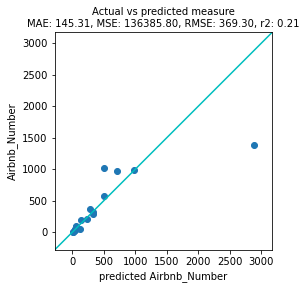

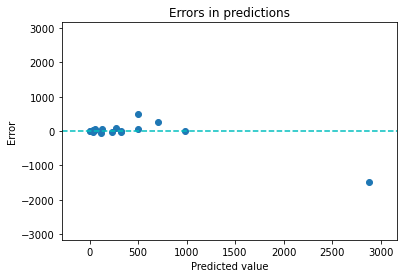

In [23]:
y_test_pred_rfe = model.predict(X_test)
pa_rfe = PredictedAccuracy(y_test, y_test_pred_rfe)
pa_rfe.plot_scatter()

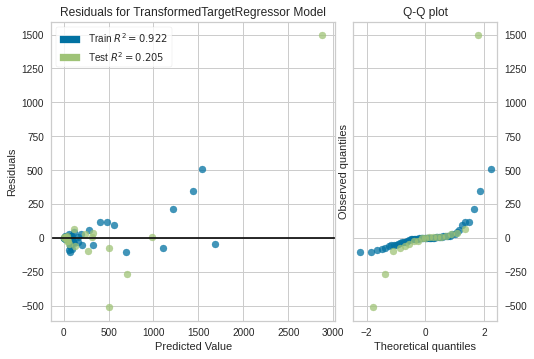

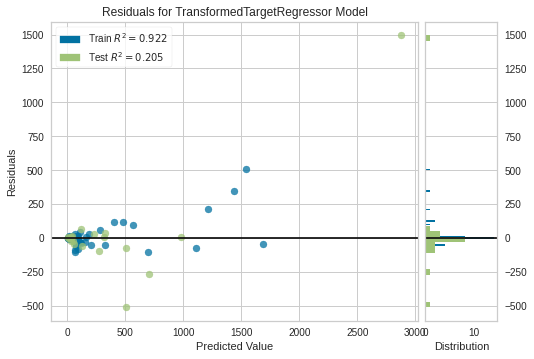

ResidualsPlot(ax=<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
              estimator=TransformedTargetRegressor(regressor=GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                                                                     Pipeline(steps=[('imputer',
                                                                                                                      IterativeImputer()),
                                                                                                                     ('pt',
                                                                                                                      PowerTransformer())])),
                                                                                                    ('rfe',
                                                                                                 

In [24]:
from yellowbrick.regressor.residuals import residuals_plot

residuals_plot(
    model, X_train, y_train, X_test, y_test, hist=False, qqplot=True, is_fitted=True
)

residuals_plot(
    model, X_train, y_train, X_test, y_test, hist=True, qqplot=False, is_fitted=True
)

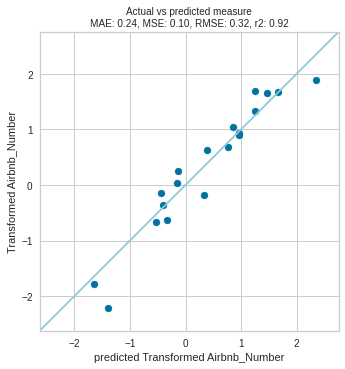

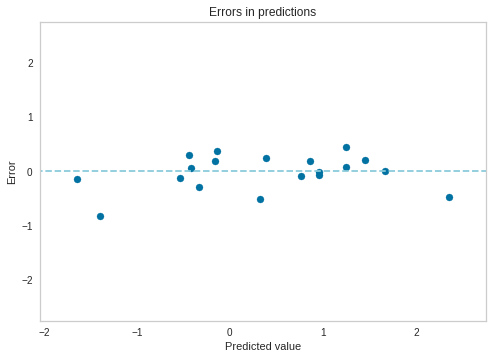

In [25]:
pw = PowerTransformer()
pw.fit(y_train.values.reshape(-1, 1))
####################Tranform y_hat####################
y_test_pred_transformed = model.predict(X_test)
y_test_pred_transformed = pw.transform(y_test_pred_transformed.reshape(-1, 1)).flatten()
# plt.hist(y_test_pred_transformed, color="b", alpha=0.7)
####################Trasform y####################
y_test_transformed = pd.Series(pw.transform(y_test.values.reshape(-1, 1)).flatten())
y_test_transformed.name = "Transformed Airbnb_Number"

pa_rfe = PredictedAccuracy(y_test_transformed, y_test_pred_transformed)
pa_rfe.plot_scatter()

# Sensitivity Analysis

In [26]:
X_train_rfe = X_train.iloc[:, cols_rfe]
X_rfe = X.iloc[:, cols_rfe]

pipe_sens = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", myRegressor)])

model_sens = TransformedTargetRegressor(
    regressor=pipe_sens, transformer=PowerTransformer()
)

model_sens.fit(X_train_rfe, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('imputer',
                                                                       IterativeImputer()),
                                                                      ('pt',
                                                                       PowerTransformer())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

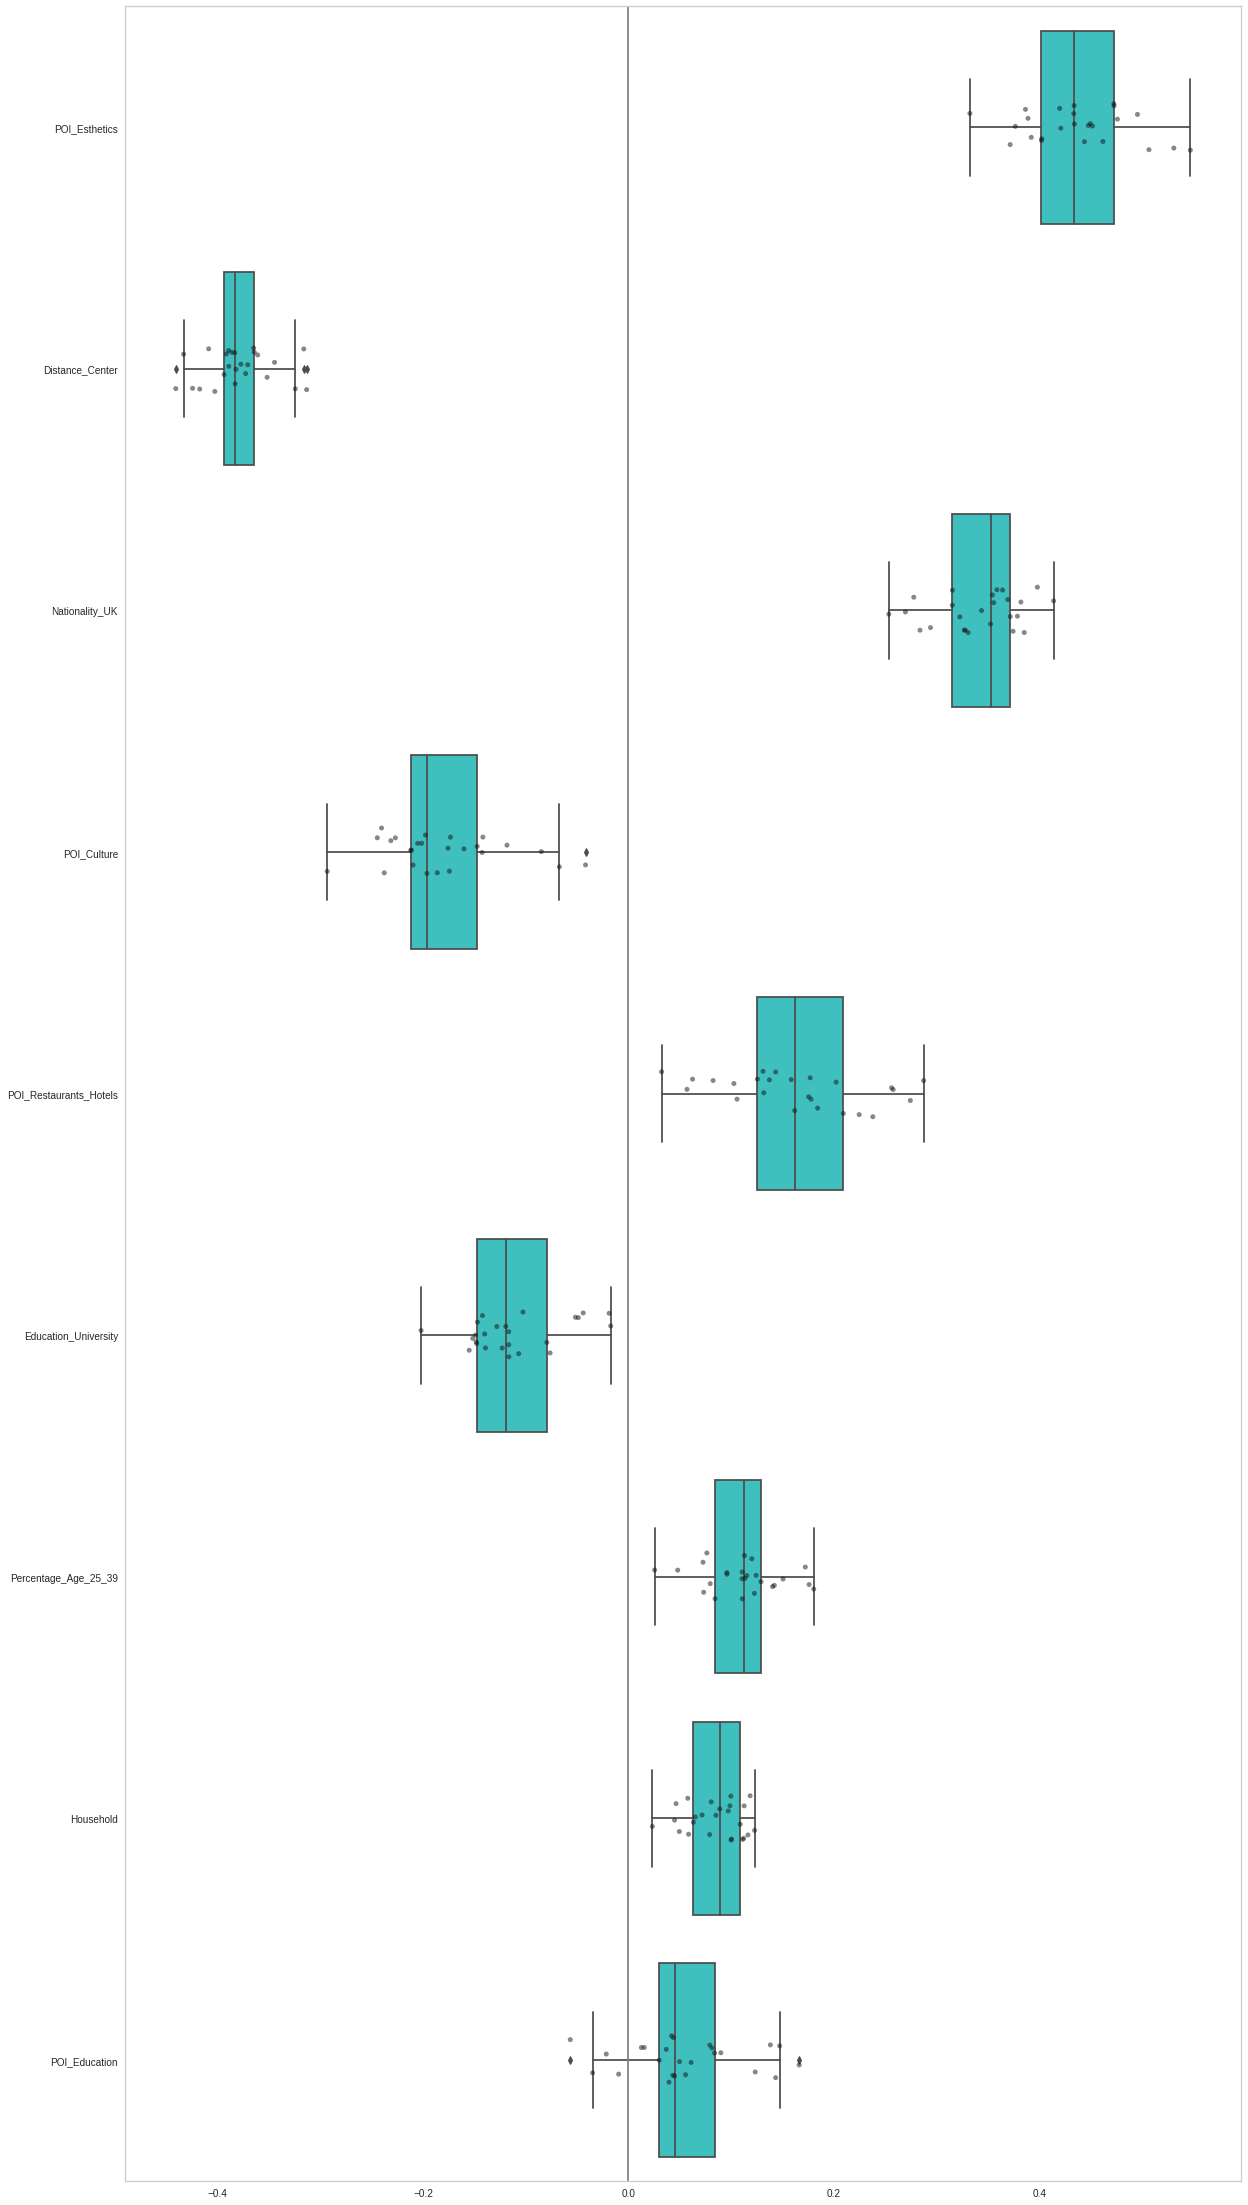

In [27]:
cv_rfe = cross_validate(
    model_sens,
    X_rfe,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_rfe = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_rfe["estimator"]],
    columns=X_rfe.columns,
)

medians_rfe = coefs_rfe.median()
medians_rfe = medians_rfe.reindex(medians_rfe.abs().sort_values(ascending=False).index)
coefs_rfe = coefs_rfe[medians_rfe.index]


plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_rfe, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_rfe, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")

In [36]:
f = open("linear_best_neighbouhood.txt", "a")

for col in coefs_rfe.columns:
    f.write(col)
    f.write("\n")
f.close()

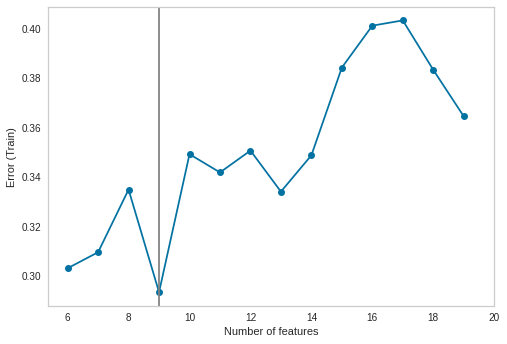

In [28]:
score_features = -model.regressor_.cv_results_["mean_test_score"]
n_features = []
for i in model.regressor_.cv_results_["params"]:
    n_features.append(i["rfe__n_features_to_select"])

id_min_score = score_features.argmin()

plt.plot(n_features, score_features, marker="o")
plt.axvline(x=n_features[id_min_score], color=".5")

plt.xlabel("Number of features")
plt.ylabel("Error (Train)")
plt.xticks(np.arange(min(n_features), max(n_features) + 2, 2.0))
plt.show()

# Watermark

In [29]:
%load_ext watermark

In [30]:
# NBVAL_IGNORE_OUTPUT
%watermark -a "Ernesto Gregori" -u -d -t -v -m -g -wb

Author: Ernesto Gregori

Last updated: 2021-04-20 16:11:19

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.8.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: cd4d9cdabbedd9c9aa1546bff7bfdab61d46a6b1

Git branch: egregorimar/gwr

Watermark: 2.2.0



In [31]:
# NBVAL_IGNORE_OUTPUT
%watermark -iv

pandas    : 1.2.3
seaborn   : 0.11.1
geopandas : 0.9.0
matplotlib: 3.3.4
numpy     : 1.20.2
urbana    : 0.1.0
sklearn   : 0.23.2

